In [ ]:
!pip3 install pmdarima

In [ ]:
# Import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


warnings.simplefilter('ignore')

In [ ]:
data = pd.read_csv('Dataset6_ftse.csv',names = ['ftse'])


**Applying KPSS and ADF test**

1. ADF test

In [ ]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = data[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('ftse')

Results of Dickey-Fuller Test for  ftse 

Test Statistic                  -2.315797
p-value                          0.166924
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


2. KPSS test

In [ ]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(atr):
    timeseries = data[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('ftse')

Results of KPSS Test for  ftse
Test Statistic            0.348183
p-value                   0.099490
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For ADF test, we can see that the p-value  is more than 0.05. Thus, from ADF test, we can say that the dataset is non-stationary.

For KPSS test, Test Statistic is less than Critical Value, thus we fail to reject the null hypothesis. Thus, from KPSS test, we can say that the dataset is stationary.

Since, both tests conclude that the series is stationary, therefore, the dataset is concluded as Trend-Stationary.



---



Making dataset stationary with differencing


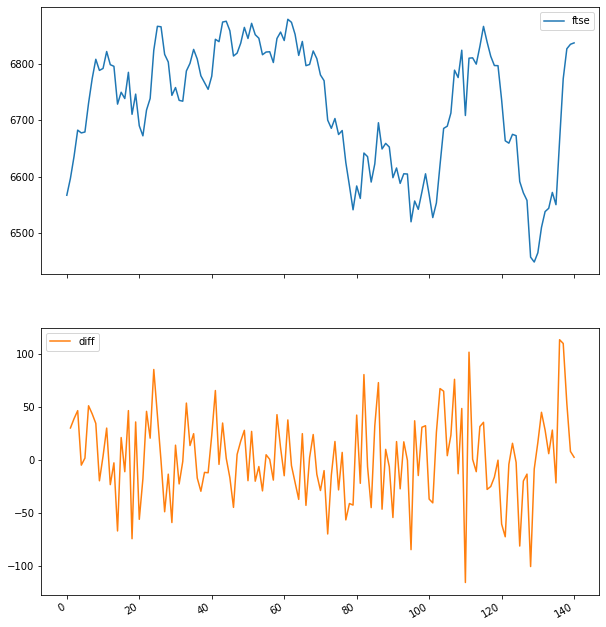

In [ ]:
# Differencing
data['diff'] = data['ftse'].diff(periods=1)

data.plot(subplots=True, figsize=(10,12))
plt.show()



---



Applying Exponential Smoothening

In [ ]:
#List of least mse and mae
mseses=[]
msedes=[]
msetes=[]
maeses=[]
maedes=[]
maetes=[]

**Single Exponential Smoothing**

In [ ]:
#Defining Single Exponential Smoothing function ses
def ses(arr,alpha):
    arr1 = [arr[0]]
    for i in range(1, len(arr)):
        arr1.append(alpha * arr[i-1] + (1 - alpha) * arr1[i-1])
    return arr1

In [ ]:
#Defining Mean of Squared Error Function mse
def mse(arr1,arr2):
  arr3=[0]
  for i, j in zip(arr1, arr2):
    arr3.append(i-j)
  Sum=0
  for i in arr3:
    sqr=i**2
    Sum+=sqr
  mse=Sum/(len(arr2)-1)
  return mse

In [ ]:
#Function to make list of demand with interval 'n'
def dem_n(arr,n):
  arr1=[arr[0]]
  for i in range(1,len(arr)):
    if i%n==0:  
      arr1.append(arr[i])
  return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  5171.94239035866
Mean of Square Errors for alpha = 0.5 is:  2403.0625832316387
Mean of Square Errors for alpha = 0.8 is:  1740.5437338464578


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8 is: ",mae3)

Mean Absolute Errors for alpha = 0.2 is:  54.98037701204862
Mean Absolute Errors for alpha = 0.5 is:  38.08876558053727
Mean Absolute Errors for alpha = 0.8 is:  32.25663133803287


alpha:  0.8


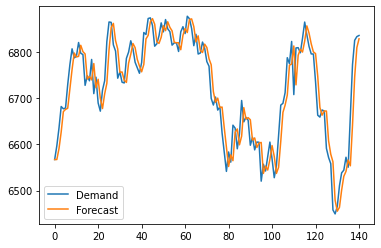

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])


**Double Exponential Smoothing**

In [ ]:
#Defining Double Exponential Smoothing function des
def des(arr,alpha,beta):
  a=[arr[0]]
  l=len(arr)
  b=[(arr[l-1]-arr[0])/(l-1)]
  arr1 = [arr[0]]
  arr1.append(a[0]+b[0])
  for i in range(1,len(arr)-1):
      a.append(alpha * arr[i] + (1 - alpha) * (a[i-1]+b[i-1]))
      b.append(beta * (a[i]-a[i-1]) + (1 - beta) * (b[i-1]))        
      arr1.append(a[i]+b[i])
  return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  5816.577466797912
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  2295.014558620508
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  2216.1017678573107


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3 is:  59.13634582887767
Mean Absolute Errors for alpha = 0.5,beta= 0.6 is:  39.06086559749912
Mean Absolute Errors for alpha = 0.8,beta= 0.9 is:  38.014374364416135


alpha:  0.8
beta:  0.9


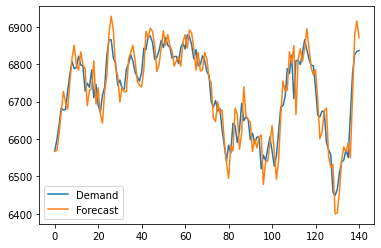

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])

**Triple Exponential Smoothing**

In [ ]:
#Defining initial trend
def initial_trend(arr, slen):
    Sum = 0
    for i in range(slen):
        Sum += float(arr[i+slen] - arr[i]) / slen
    return Sum / slen

In [ ]:
#Defining initial seasonal
def initial_seasonal(arr, slen):
    arr1 = {}
    s_avg = []
    m = int(len(arr)/slen)
    for j in range(m):
        s_avg.append(sum(arr[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        Sum = 0
        for j in range(m):
            Sum += arr[slen*j+i]-s_avg[j]
        arr1[i] = Sum/m
    return arr1

In [ ]:
#Defining Triple Exponential Smoothing function tes with interval 'n'
def tes(arr, slen, alpha, beta, gamma, n):
    arr1 = []
    seasonals = initial_seasonal(arr, slen)
    for i in range(len(arr)+n):
        if i == 0:
            smooth = arr[0]
            trend = initial_trend(arr, slen)
            arr1.append(arr[0])
            continue
        if i >= len(arr):
            m = i - len(arr) + 1
            arr1.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = arr[i]
            lsmooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-lsmooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            arr1.append(smooth+trend+seasonals[i%slen])
    return arr1

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  647.4059976920892
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  367.726622468638
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  946.8359299309225


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  19.828456159768542
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  15.12996770767488
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  23.826123373666555


alpha:  0.5
beta:  0.6
gamma:  0.7


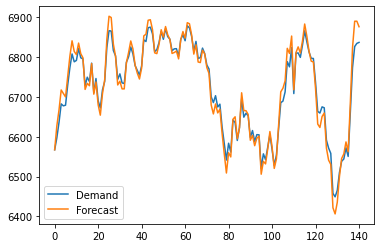

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])



---



For 1 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  5171.94239035866
Mean of Square Errors for alpha = 0.5 is:  2403.0625832316387
Mean of Square Errors for alpha = 0.8 is:  1740.5437338464578


alpha:  0.8


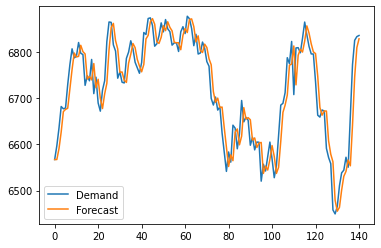

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  5816.577466797912
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  2295.014558620508
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  2216.1017678573107


alpha:  0.8
beta:  0.9


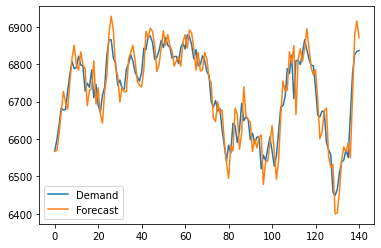

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,1)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  647.4059976920892
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  367.726622468638
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  946.8359299309225


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  19.828456159768542
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  15.12996770767488
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  23.826123373666555


alpha:  0.5
beta:  0.6
gamma:  0.7


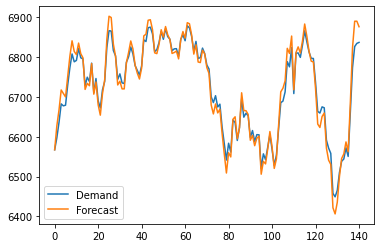

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 2 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  8137.848047222117
Mean of Square Errors for alpha = 0.5 is:  4803.368785679945
Mean of Square Errors for alpha = 0.8 is:  3471.9091693560686


alpha:  0.8


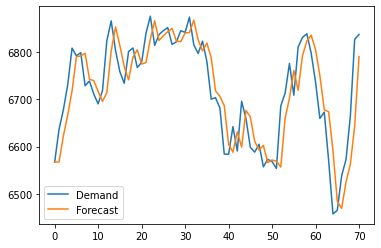

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  11461.342763944751
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  4823.669826749591
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  4122.706425485765


alpha:  0.8
beta:  0.9


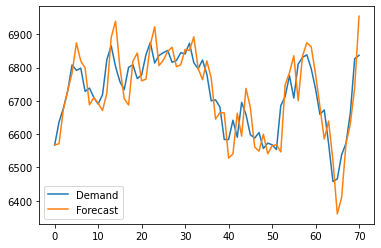

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,2)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  2224.285584378022
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  807.3607647329993
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  1948.0995442381422


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  35.721749458003984
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  21.074084587339982
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  34.83698004502979


alpha:  0.5
beta:  0.6
gamma:  0.7


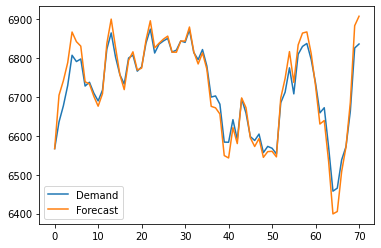

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 4 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  12467.609907645183
Mean of Square Errors for alpha = 0.5 is:  9188.76038172739
Mean of Square Errors for alpha = 0.8 is:  7593.305922549386


alpha:  0.8


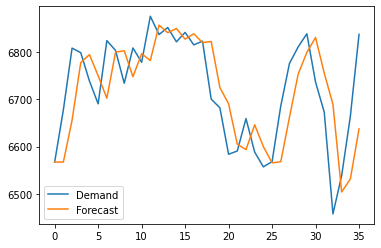

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  15401.457167757568
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  13404.463744980128
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  9464.165011677607


alpha:  0.8
beta:  0.9


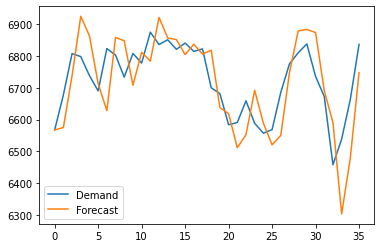

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,4)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  7699.829421728787
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  1791.7880715479178
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  4310.6444586270045


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  72.47666908850975
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  30.872124933930838
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  50.072508381954826


alpha:  0.5
beta:  0.6
gamma:  0.7


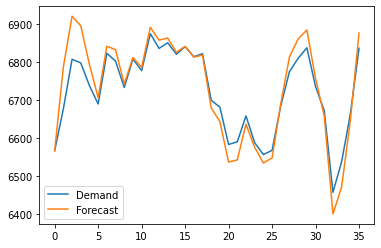

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 8 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  15913.473387835074
Mean of Square Errors for alpha = 0.5 is:  13682.680354119695
Mean of Square Errors for alpha = 0.8 is:  14390.47368001119


alpha:  0.5


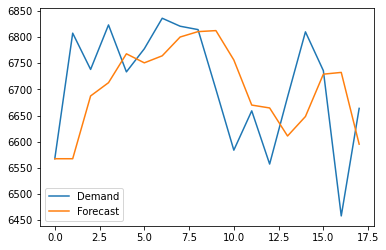

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  19830.65295473028
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  18726.595877217376
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  26932.358386033648


alpha:  0.5
beta:  0.6


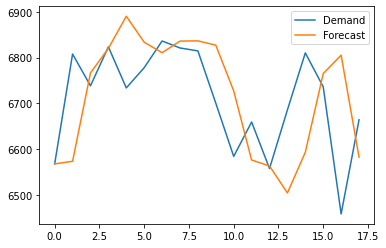

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,8)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  54252.743199109165
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  7420.608818407491
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  8708.618419038101


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  198.0753459893112
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  58.627404074495445
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  67.14126145467077


alpha:  0.5
beta:  0.6
gamma:  0.7


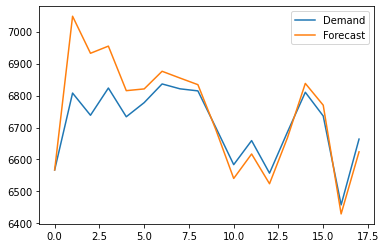

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 12 Unit

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  20108.220880112614
Mean of Square Errors for alpha = 0.5 is:  16481.308407686804
Mean of Square Errors for alpha = 0.8 is:  15199.33303295701


alpha:  0.8


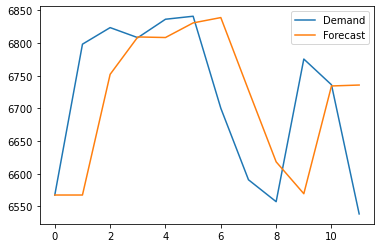

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  26628.75506420409
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  23510.866977295973
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  24738.960725997546


alpha:  0.5
beta:  0.6


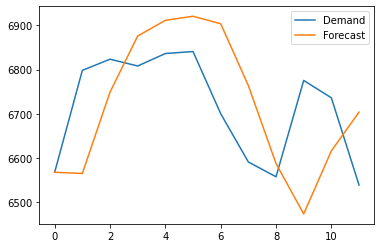

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,12)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  72007.30748935297
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  10679.672952806239
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  10327.893420313369


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  244.88793310566493
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  72.01973805329453
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  76.00055084543442


alpha:  0.8
beta:  0.9
gamma:  0.95


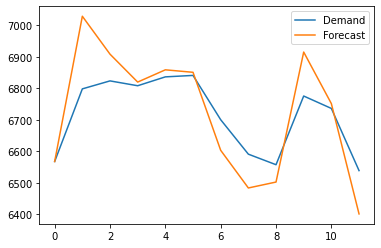

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 24 Interval

**Single Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  22501.537320934436
Mean of Square Errors for alpha = 0.5 is:  21493.09298105477
Mean of Square Errors for alpha = 0.8 is:  22357.29334098568


alpha:  0.5


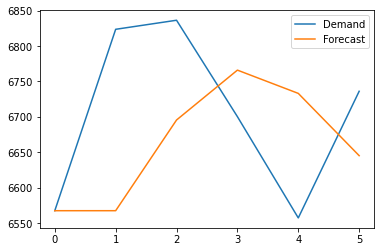

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [ ]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  24186.776243994726
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  33096.679000847485
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  41802.20416478356


alpha:  0.2
beta:  0.3


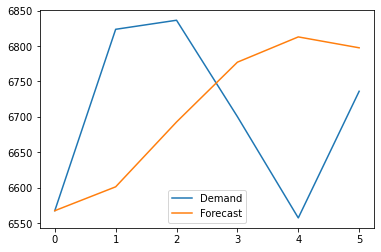

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

**Triple Exponential Smoothing**

In [ ]:
#Creating demand list in 'n' intervals
demand=dem_n(data.ftse,24)

In [ ]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [ ]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  115810.24131187542
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  22036.10848782094
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  16999.16940131579


In [ ]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  303.17644031093477
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  109.5232362083337
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  104.96425241526686


alpha:  0.8
beta:  0.9
gamma:  0.95


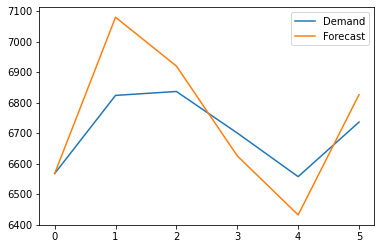

In [ ]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [ ]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)



---

Least MSE and MAE values are


In [ ]:
print("Least MSE ses")
print(mseses)
print("Least MSE des")
print(msedes)
print("Least MSE tes")
print(msetes)


print("Least MAE ses")
print(maeses)
print("Least MAE des")
print(maedes)
print("Least MAE tes")
print(maetes)


Least MSE ses
[1740.5437338464578, 3471.9091693560686, 7593.305922549386, 13682.680354119695, 15199.33303295701, 21493.09298105477]
Least MSE des
[2216.1017678573107, 4122.706425485765, 9464.165011677607, 18726.595877217376, 23510.866977295973, 24186.776243994726]
Least MSE tes
[367.726622468638, 807.3607647329993, 1791.7880715479178, 7420.608818407491, 10327.893420313369, 16999.16940131579]
Least MAE ses
[15.12996770767488, 15.12996770767488, 21.074084587339982, 30.872124933930838, 58.627404074495445, 72.01973805329453]
Least MAE des
[15.12996770767488, 15.12996770767488, 21.074084587339982, 30.872124933930838, 58.627404074495445]
Least MAE tes
[15.12996770767488, 21.074084587339982, 30.872124933930838, 58.627404074495445, 72.01973805329453, 104.96425241526686]




---



Applying ACF and PACF

<function matplotlib.pyplot.show>

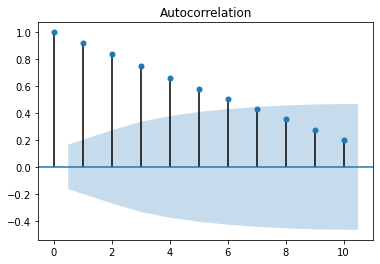

In [ ]:
#Plotting ACF
plot_acf(data.ftse,lags=10)
plt.show

<function matplotlib.pyplot.show>

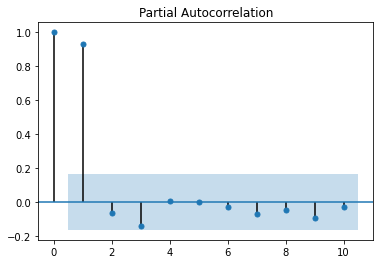

In [ ]:
#plotting PACF
plot_pacf(data.ftse,lags=10)
plt.show



---



Applying AR, MA, ARIMA Models

                              ARMA Model Results                              
Dep. Variable:                   ftse   No. Observations:                  141
Model:                     ARMA(0, 0)   Log Likelihood                -862.577
Method:                           css   S.D. of innovations            109.796
Date:                Mon, 01 Mar 2021   AIC                           1729.154
Time:                        05:42:06   BIC                           1735.051
Sample:                             0   HQIC                          1731.550
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6723.3963      9.247    727.127      0.000    6705.273    6741.519


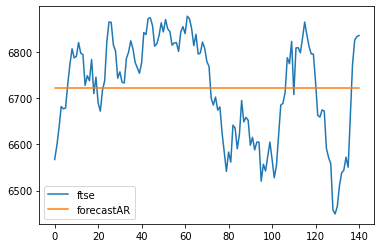

In [ ]:
#AR

#fit model
model=ARIMA(data['ftse'], order=(0,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastAR'] = model_fit.predict()
data[['ftse','forecastAR']].plot()

In [ ]:
mse=mean_squared_error(data.ftse,data.forecastAR.dropna())
print("MSE for AR is:",mse)

MSE for AR is: 12055.246580725321


In [ ]:
mae=mean_absolute_error(data.ftse,data.forecastAR.dropna())
print("MAE for AR is:",mae)

MAE for AR is: 95.14101202152808


                              ARMA Model Results                              
Dep. Variable:                   ftse   No. Observations:                  141
Model:                     ARMA(0, 0)   Log Likelihood                -862.577
Method:                           css   S.D. of innovations            109.796
Date:                Mon, 01 Mar 2021   AIC                           1729.154
Time:                        05:42:07   BIC                           1735.051
Sample:                             0   HQIC                          1731.550
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6723.3963      9.247    727.127      0.000    6705.273    6741.519


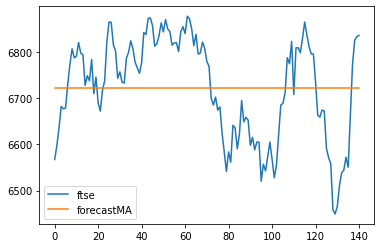

In [ ]:
#MA

#fit model
model=ARIMA(data['ftse'].dropna(), order=(0,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastMA'] = model_fit.predict()
data[['ftse','forecastMA']].plot()

In [ ]:
mse=mean_squared_error(data.ftse,data.forecastMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 12055.246580725321


In [ ]:
mae=mean_absolute_error(data.ftse,data.forecastMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 95.14101202152808


                             ARIMA Model Results                              
Dep. Variable:                 D.diff   No. Observations:                  139
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -756.914
Method:                           css   S.D. of innovations             56.064
Date:                Mon, 01 Mar 2021   AIC                           1517.828
Time:                        05:42:07   BIC                           1523.697
Sample:                             1   HQIC                          1520.213
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1981      4.755     -0.042      0.967      -9.518       9.122


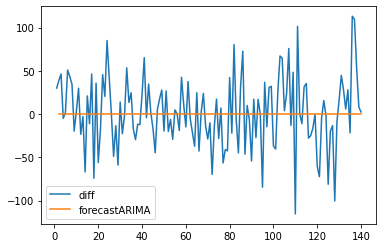

In [ ]:
#ARIMA

#fit model
model=ARIMA(data['diff'].dropna(), order=(0,1,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastARIMA'] = model_fit.predict()
data[['diff','forecastARIMA']].plot()

In [ ]:
mse=mean_squared_error(data.ftse[0:-2],data.forecastARIMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 45197080.703873575


In [ ]:
mae=mean_absolute_error(data.ftse[0:-2],data.forecastARIMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 6721.981510791366




---



Applying Auto ARIMA

In [ ]:
import pmdarima as pm
model = pm.auto_arima(data.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1439.769, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1437.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1438.793, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1438.848, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1435.383, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -716.691
Date:                Mon, 01 Mar 2021   AIC                           1435.383
Time:                        05:42:08   BIC                           1438.324
Sample:                             0   HQIC                          1436.578
                                - 141                                       

# Best model:  ARIMA(0,1,0)(0,0,0)[0]          


Final Result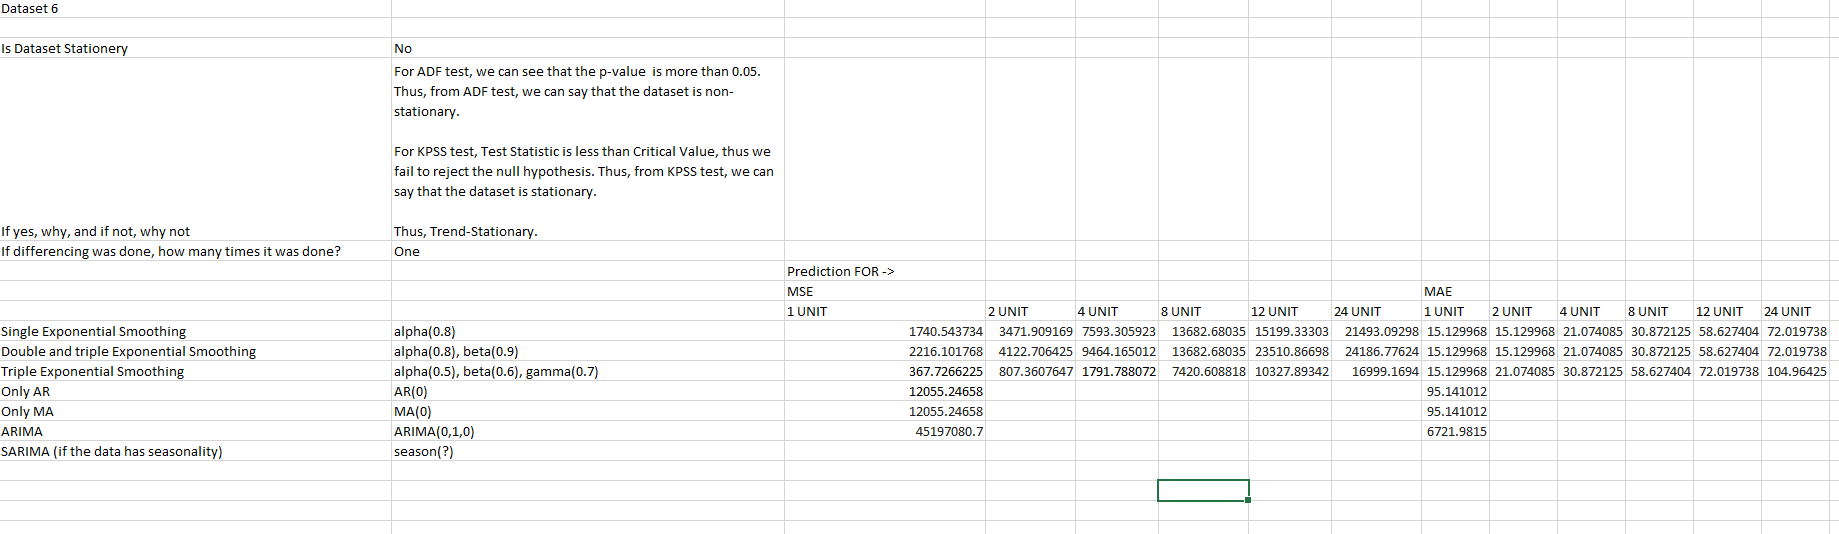